<a href="https://colab.research.google.com/github/mmore500/hstrat-synthesis/blob/main/pylib/track_outlier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install hstrat downstream iplotx teeplot

  Preparing metadata (setup.py) ... done
  Created wheel for distutils-strtobool: filename=distutils_strtobool-0.1.0-py3-none-any.whl size=1661 sha256=093bbaca83bf4a0de9c3ef9e0a3f46089545c5d8cf296ca737d9ffef67f43694
  Stored in directory: /root/.cache/pip/wheels/d5/60/59/af825a16b027a20e58d52ba289e1589437d404664f35d3f50e
Successfully built distutils-strtobool


In [1]:
import itertools as it
import base64

In [2]:
import numpy as xp  # should be possible to substitute cupy
xp.__version__

'2.3.5'

In [3]:
rle = "ERETQB4eHWkQ7xD4eYZosBQZFixOBHmtFeehExrKVhURLRAqGxeIlSO1JYZP6DRi69rop7TQCkvWTIag7kAS8g"
padded_bytes = base64.b64decode(rle + "==")
padded_bits = "".join(f"{b:08b}" for b in padded_bytes)
rule_table = xp.fromiter(map(int, padded_bits), dtype=xp.uint16)
rule_table

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,

In [4]:
def pack_neighborhoods(cells : xp.ndarray) -> xp.ndarray:
  res = xp.zeros_like(cells, dtype=xp.uint16)
  for i, (dy, dx) in enumerate(it.product((-1, 0, 1), repeat=2)):
      res |= xp.roll(cells << i, shift=(-dy, -dx), axis=(0, 1))
  return res


In [5]:
def test_pack_neighborhoods():
    # --- Case 1: The "Center" bit (Bit 4) ---
    # If a cell is alone, it should only see itself.
    grid = xp.zeros((3, 3), dtype=xp.uint16)
    grid[1, 1] = 1
    packed = pack_neighborhoods(grid)

    assert xp.array_equal(
        packed,
        xp.array(
            [
                [2**8, 2**7, 2**6],
                [2**5, 2**4, 2**3],
                [2**2, 2**1, 2**0],
            ],
            dtype=xp.uint16,
        ),
    )


    # --- Case 2: Neighbor Perspective ---
    # The cell at (1, 0) is to the WEST of the center.
    # Therefore, looking EAST, it sees the active center.
    # Bit 5 is East. 1 << 5 = 32.
    assert packed[1, 0] == 32, f"Expected 32 (East), got {packed[1, 0]}"

    # --- Case 3: Toroidal Wrap (Corner Check) ---
    grid = xp.zeros((3, 3), dtype=xp.uint16)
    grid[0, 0] = 1
    packed = pack_neighborhoods(grid)

    # Check Bottom-Right cell (2,2).
    # From (2,2), looking South-East wraps to (0,0).
    # Bit 8 (SE) is 256. This assertion was already correct.
    assert packed[2, 2] == 256, f"Expected 256 (SE wrap), got {packed[2, 2]}"

    # Check Top-Right cell (0, 2).
    # From (0,2), looking EAST (Right) wraps to (0,0).
    # Bit 5 is East. 1 << 5 = 32.
    assert packed[0, 2] == 32, f"Expected 32 (East wrap), got {packed[0, 2]}"

    # --- Case 4: Full Grid ---
    # All neighbors active = 9 bits set (binary 111111111 = 511)
    grid = xp.ones((3, 3), dtype=xp.uint16)
    packed = pack_neighborhoods(grid)
    assert xp.all(packed == 511)

    print("All assertions passed!")

test_pack_neighborhoods()

All assertions passed!


In [6]:
def update(cells : xp.ndarray, rule: xp.ndarray) -> xp.ndarray:
  # prevent wraparound
  cells[:1], cells[-1:], cells[:, :1], cells[:, -1:] = 0, 0, 0, 0
  # apply rule
  return rule[pack_neighborhoods(cells)]


In [7]:
def parse_rle(rle_string: str) -> xp.ndarray:
  rows = []
  current_row = []
  count = ""
  max_row_length = 0

  for char in rle_string:
    if char.isdigit():
      count += char
    elif char == "b":
      num_cells = int(count) if count else 1
      current_row.extend([0] * num_cells)
      count = ""
    elif char == "o":
      num_cells = int(count) if count else 1
      current_row.extend([1] * num_cells)
      count = ""
    elif char == "$":
      rows.append(current_row)
      max_row_length = max(max_row_length, len(current_row))
      current_row = []
      count = ""
    elif char == "!":
      break

  # Append the last row if it's not empty and the string didn't end with a '$'
  if current_row:
      rows.append(current_row)
      max_row_length = max(max_row_length, len(current_row))

  # Pad rows to ensure uniform length
  padded_rows = []
  for row in rows:
    padded_rows.append(row + [0] * (max_row_length - len(row)))

  return xp.array(padded_rows, dtype=xp.uint16)


In [8]:
rle_pattern_string = "$bo$3o$2bo!"
parsed_pattern = parse_rle(rle_pattern_string)
print(parsed_pattern)

[[0 0 0]
 [0 1 0]
 [1 1 1]
 [0 0 1]]


In [9]:
grid_size = 2300
grid = xp.zeros((grid_size, grid_size), dtype=xp.uint16)

pattern_height, pattern_width = parsed_pattern.shape

offset_y = (grid_size - pattern_height) // 2
offset_x = (grid_size - pattern_width) // 2

grid[
    offset_y : offset_y + pattern_height,
    offset_x : offset_x + pattern_width
] = parsed_pattern


In [12]:
from track_ca import MultiTracker
from downstream import dstream
import tqdm

n_trackers = 0
tracker = MultiTracker(
    dstream_algo=dstream.steady_algo, dstream_S=8, dstream_bitwidth=1, N=1, backend=xp
).initialize(grid.astype(xp.bool_), R=1)

num_steps = 10
for _ in tqdm.trange(num_steps):
    grid = update(grid, rule_table)
    tracker.step(grid.astype(xp.bool_), add_random_noise=True)

print(f"Total states stored: {tracker.N}")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:23<00:00,  2.33s/it]

Total states stored: 1


In [13]:
phylos = tracker.reconstruct_phylogenies()

100%|██████████| 37/37 [00:00<00:00, 189717.91it/s]


In [14]:
# since this holds, we don't need to do any weird re-ordering of the mrca vector
for phylo in phylos:
    assert phylo[phylo["extant"] == True]["dstream_data_id"].is_monotonic_increasing

In [22]:
import hstrat
from hstrat._auxiliary_lib import (
    alifestd_mark_node_depth_asexual,
    alifestd_try_add_ancestor_id_col,
)

post_phylos = [
    alifestd_mark_node_depth_asexual(alifestd_try_add_ancestor_id_col(phylo))
    for phylo in phylos
]

decomposed_phylos = [
    {
        k: xp.array(phylo[k].to_numpy()) for k in [
            "extant",
            "dstream_data_id",
            "extant",
            "node_depth",
            "ancestor_id",
            "id",
            "hstrat_rank"
        ]
    } for phylo in post_phylos    
]
for phylo in decomposed_phylos:
    phylo["max_depth"] = int(phylo["node_depth"].max())
    phylo["n"] = len(phylo["id"])

extant_ids = decomposed_phylos[0]["dstream_data_id"][decomposed_phylos[0]["extant"] == True]

mrca_variances = xp.empty(len(extant_ids), dtype=xp.float32)
for j, extant_id in enumerate(extant_ids):
    result = xp.full((len(decomposed_phylos), len(extant_ids)), -1, dtype=xp.int64)
    for i, phylo in enumerate(decomposed_phylos):
        cur_positions = phylo["id"].copy()
        real_id = cur_positions[phylo["dstream_data_id"] == extant_id][0]
        mrca_single_vector = xp.full(phylo["n"], -1, dtype=xp.int64)
        temp = xp.full(phylo["n"], -1, dtype=xp.int64)
        target_depth = phylo["node_depth"][real_id]
        for depth in reversed(range(phylo["max_depth"] + 1)):
            if depth <= target_depth:
                target_position = cur_positions[real_id]
                temp = xp.maximum(
                    temp,
                    xp.where(
                        cur_positions == target_position,
                        target_position,
                        -1,
                    ),
                )
            depth_mask = phylo["node_depth"][cur_positions] == depth
            cur_positions[depth_mask] = phylo["ancestor_id"][cur_positions[depth_mask]]
        result[i] = phylo["hstrat_rank"][phylo["extant"] == True]
    means = result.mean(axis=0)
    mrca_variances[j] = (xp.square(result - means).mean(axis=0) / xp.square(means)).mean()

<Axes: >

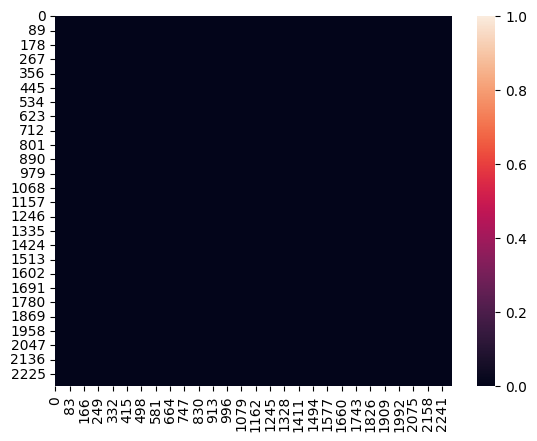

In [25]:
df = phylos[0]

import seaborn as sns
grid = xp.zeros((grid_size, grid_size))
for _, row in df[(df["state"] >= 0) & df["extant"]].iterrows():
    grid[int(row["row"]), int(row["col"])] = mrca_variances[row["dstream_data_id"]] + 1
sns.heatmap(grid)

In [ ]:
phylos[8][0][phylos[8][0]["extant"] == True]

,dstream_data_id,id,ancestor_id,hstrat_rank,hstrat_differentia_bitwidth,dstream_S,data_hex,extant,row,col,state,rank,origin_time
4,0,4,3,149,1,64,000000963ed9ce037327502c,True,118.0,113.0,1.0,149,85
11,1,11,10,149,1,64,00000096bed95a2b738b8311,True,119.0,73.0,1.0,149,85
13,2,13,12,149,1,64,00000096bed95e2b738b8311,True,119.0,74.0,1.0,149,85
14,3,14,3,149,1,64,000000963ed9ce037327502c,True,119.0,112.0,1.0,149,85
15,4,15,3,149,1,64,000000963ed9ce037327502c,True,119.0,114.0,1.0,149,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,83,115,114,149,1,64,00000096bed95e2f73892304,True,129.0,83.0,1.0,149,85
116,84,116,114,149,1,64,00000096bed95e2f73892304,True,129.0,85.0,1.0,149,85
117,85,117,114,149,1,64,00000096bed95e2f73892304,True,130.0,83.0,1.0,149,85
118,86,118,101,149,1,64,00000096bed95a2f73892304,True,130.0,84.0,1.0,149,85
